In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

sns.set_theme(style='whitegrid')

csv_path = r"FAOSTAT_data_en_10-14-2025.csv"

# Read CSV
df = pd.read_csv(csv_path, dtype=str)
print('Raw rows:', len(df))

Raw rows: 1782


In [ ]:
# Show columns
print('Columns:', list(df.columns))
print('Head:')
print(df.head(6).to_string(index=False))

Columns: ['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Year Code', 'Year', 'Item Code', 'Item', 'Months Code', 'Months', 'Element Code', 'Element', 'Unit', 'Value', 'Flag', 'Flag Description', 'Note']
Head:
Domain Code                 Domain Area Code (M49)   Area Year Code Year Item Code                                       Item Months Code   Months Element Code Element Unit     Value Flag                  Flag Description              Note
         CP Consumer Price Indices             124 Canada      2000 2000     23013 Consumer Prices, Food Indices (2015 = 100)        7001  January         6125   Value  NaN 64.948845    X Figure from external organization base year is 2015
         CP Consumer Price Indices             124 Canada      2000 2000     23013 Consumer Prices, Food Indices (2015 = 100)        7002 February         6125   Value  NaN 64.736363    X Figure from external organization base year is 2015
         CP Consumer Price Indices             124 Canada      20

In [ ]:
# Keep original Year and Months columns; coerce errors where data is missing
for col in ['Year','Months','Area','Item','Value']:
    if col not in df.columns:
        raise RuntimeError(f'Missing expected column: {col}')

In [6]:
# Filter for Canada and food index items
mask = (df['Area'] == 'Canada') & df['Item'].str.contains('Food Indices', na=False)
df_can = df.loc[mask].copy()
print(f"Filtered Canada rows: {len(df_can)}")

Filtered Canada rows: 303


In [7]:
# Convert columns
df_can['Value'] = pd.to_numeric(df_can['Value'], errors='coerce')
df_can['Year'] = df_can['Year'].astype(str)
# Parse month names + year into a datetime column
# Some rows may have non-month values; coerce to NaT
df_can['date'] = pd.to_datetime(df_can['Year'] + ' ' + df_can['Months'], format='%Y %B', errors='coerce')
print('After filtering and conversion, rows:', len(df_can))

After filtering and conversion, rows: 303


In [ ]:
# Drop rows without a valid date or value
df_can = df_can.dropna(subset=['date','Value']).sort_values('date')
print('After parsing dates and values:', len(df_can))
print(df_can[['date','Year','Months','Value']].head(8).to_string(index=False))


After parsing dates and values: 303
      date Year   Months     Value
2000-01-01 2000  January 64.948845
2000-02-01 2000 February 64.736363
2000-03-01 2000    March 65.090500
2000-04-01 2000    April 65.232155
2000-05-01 2000      May 65.869603
2000-06-01 2000     June 66.436223
2000-07-01 2000     July 66.861188
2000-08-01 2000   August 66.507051


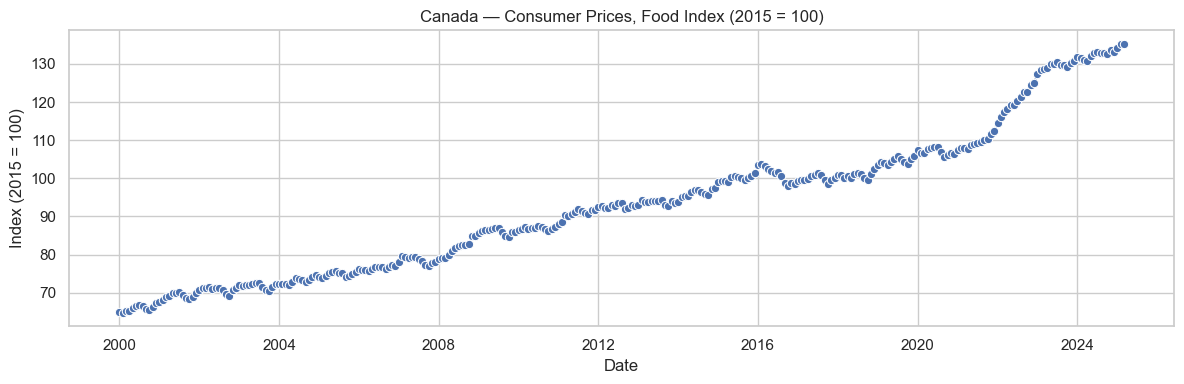

In [ ]:
# Time series plot
plt.figure(figsize=(12,4))
ax = sns.lineplot(data=df_can, x='date', y='Value', marker='o')
ax.set_title('Canada — Consumer Prices, Food Index (2015 = 100)')
ax.set_ylabel('Index (2015 = 100)')
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

C:\Users\kylef\AppData\Local\Temp\ipykernel_1712\1112170786.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([pd.to_datetime(str(m), format='%m').strftime('%b') for m in month_order])


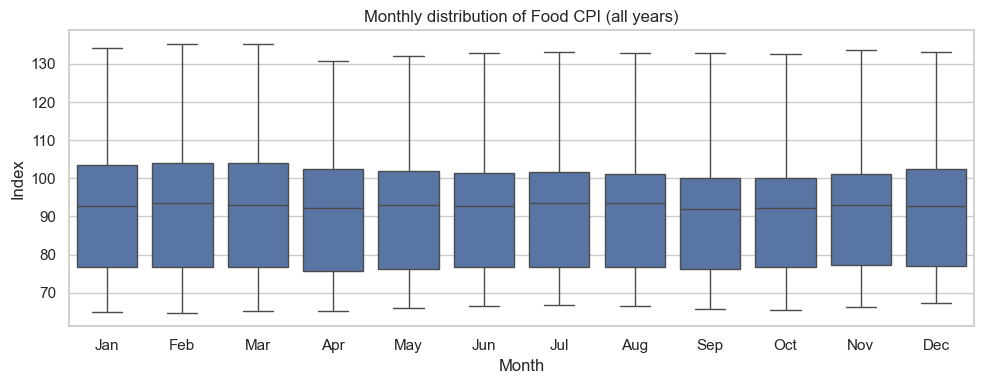

In [ ]:
# Monthly seasonality boxplot 
df_can['month'] = df_can['date'].dt.month
month_order = list(range(1,13))
plt.figure(figsize=(10,4))
ax = sns.boxplot(x='month', y='Value', data=df_can, order=month_order)
ax.set_xticklabels([pd.to_datetime(str(m), format='%m').strftime('%b') for m in month_order])
ax.set_title('Monthly distribution of Food CPI (all years)')
ax.set_xlabel('Month')
ax.set_ylabel('Index')
plt.tight_layout()
plt.show()

C:\Users\kylef\AppData\Local\Temp\ipykernel_1712\3501019343.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=annual, x='year_int', y='Value', palette='viridis')


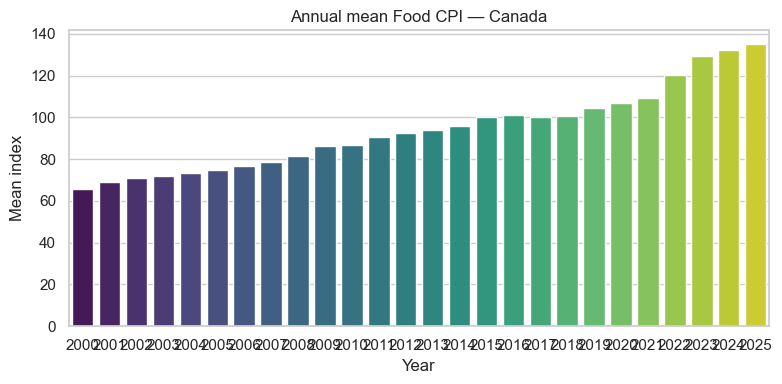

In [ ]:
# Annual means bar plot
df_can['year_int'] = df_can['date'].dt.year
annual = df_can.groupby('year_int')['Value'].mean().reset_index()
plt.figure(figsize=(8,4))
ax = sns.barplot(data=annual, x='year_int', y='Value', palette='viridis')
ax.set_title('Annual mean Food CPI — Canada')
ax.set_xlabel('Year')
ax.set_ylabel('Mean index')
plt.tight_layout()
plt.show()